# **1. 간단한 CNN 모델 만들기**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 배치크기 * 채널(1 : 그레이스케일, 3 : 트루컬러) * 너비 * 높이

inputs = torch.Tensor(1, 1, 28, 28)

print(inputs.shape)

torch.Size([1, 1, 28, 28])


In [3]:
# 첫번째 Conv2D

conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 'same')
out = conv1(inputs)

print(out.shape)

torch.Size([1, 32, 28, 28])


In [4]:
# 첫번재 MaxPool2D

pool = nn.MaxPool2d(kernel_size = 2)
out = pool(out)

print(out.shape)

torch.Size([1, 32, 14, 14])


In [5]:
# 두번째 Conv2D

conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same')
out = conv2(out)

print(out.shape)

torch.Size([1, 64, 14, 14])


In [6]:
# 두번재 MaxPool2D

pool = nn.MaxPool2d(kernel_size = 2)
out = pool(out)

print(out.shape)

torch.Size([1, 64, 7, 7])


In [7]:
flatten = nn.Flatten()
out = flatten(out)

print(out.shape) # 64 * 7 * 7

torch.Size([1, 3136])


In [8]:
fc = nn.Linear(3136, 10)
out = fc(out)

print(out.shape)

torch.Size([1, 10])


# **2. CNN으로 MNIST 분류하기**

In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

In [12]:
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

In [13]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [14]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [15]:
loader = DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = True
)

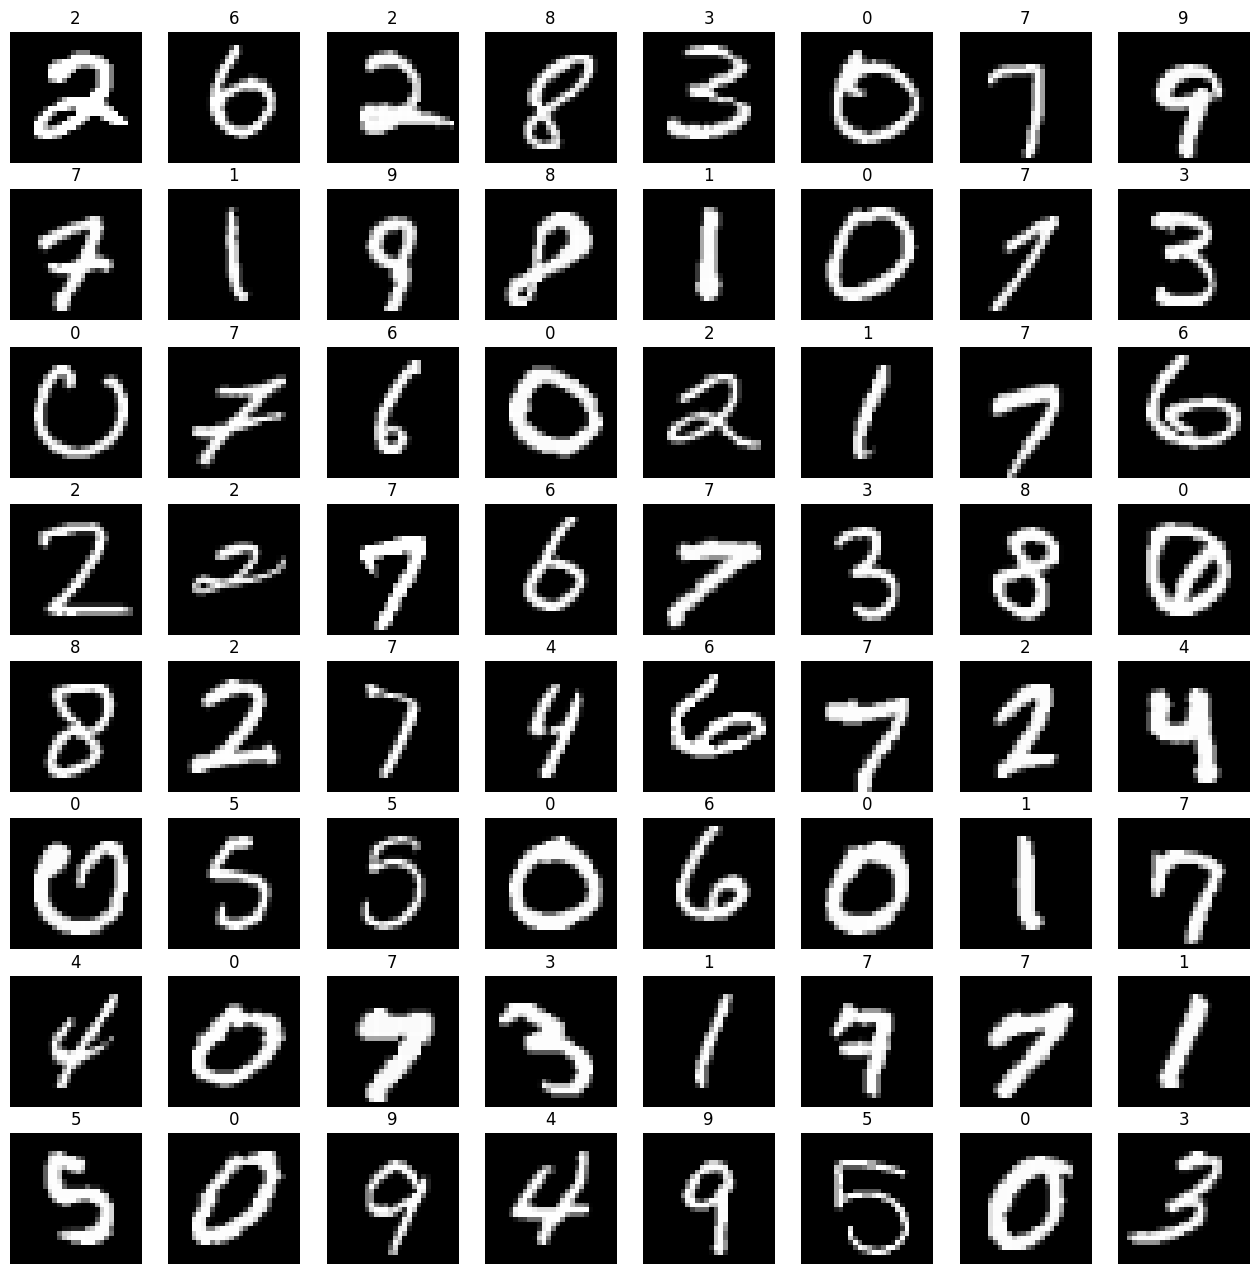

In [16]:
imgs, labels = next(iter(loader))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [17]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size = 3, padding = 'same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),

    nn.Conv2d(32, 64, kernel_size = 3, padding = 'same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 10)
).to(device)

In [18]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=10, bias=True)
)

In [19]:
optimizer= optim.Adam(model.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs + 1) :
    sum_losses = 0
    sum_accuracy = 0

    for x_batch, y_batch in loader :
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis = 1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accuracy = sum_accuracy + acc

    avg_loss = sum_losses / len(loader)
    avg_accuracy = sum_accuracy / len(loader)

    print(f'Epoch : {epoch : 4d} / {epochs} Loss : {avg_loss : .6f} Accuracy : {avg_accuracy : .2f}%')

Epoch :    0 / 10 Loss :  0.185522 Accuracy :  94.54%
Epoch :    1 / 10 Loss :  0.054133 Accuracy :  98.34%
Epoch :    2 / 10 Loss :  0.039527 Accuracy :  98.77%
Epoch :    3 / 10 Loss :  0.031534 Accuracy :  98.99%
Epoch :    4 / 10 Loss :  0.025645 Accuracy :  99.16%
Epoch :    5 / 10 Loss :  0.020526 Accuracy :  99.36%
Epoch :    6 / 10 Loss :  0.017427 Accuracy :  99.44%
Epoch :    7 / 10 Loss :  0.014295 Accuracy :  99.55%
Epoch :    8 / 10 Loss :  0.011966 Accuracy :  99.63%
Epoch :    9 / 10 Loss :  0.009142 Accuracy :  99.69%
Epoch :   10 / 10 Loss :  0.007884 Accuracy :  99.72%


In [20]:
test_loader = DataLoader(
    dataset = test_data,
    batch_size = 64,
    shuffle = False
)


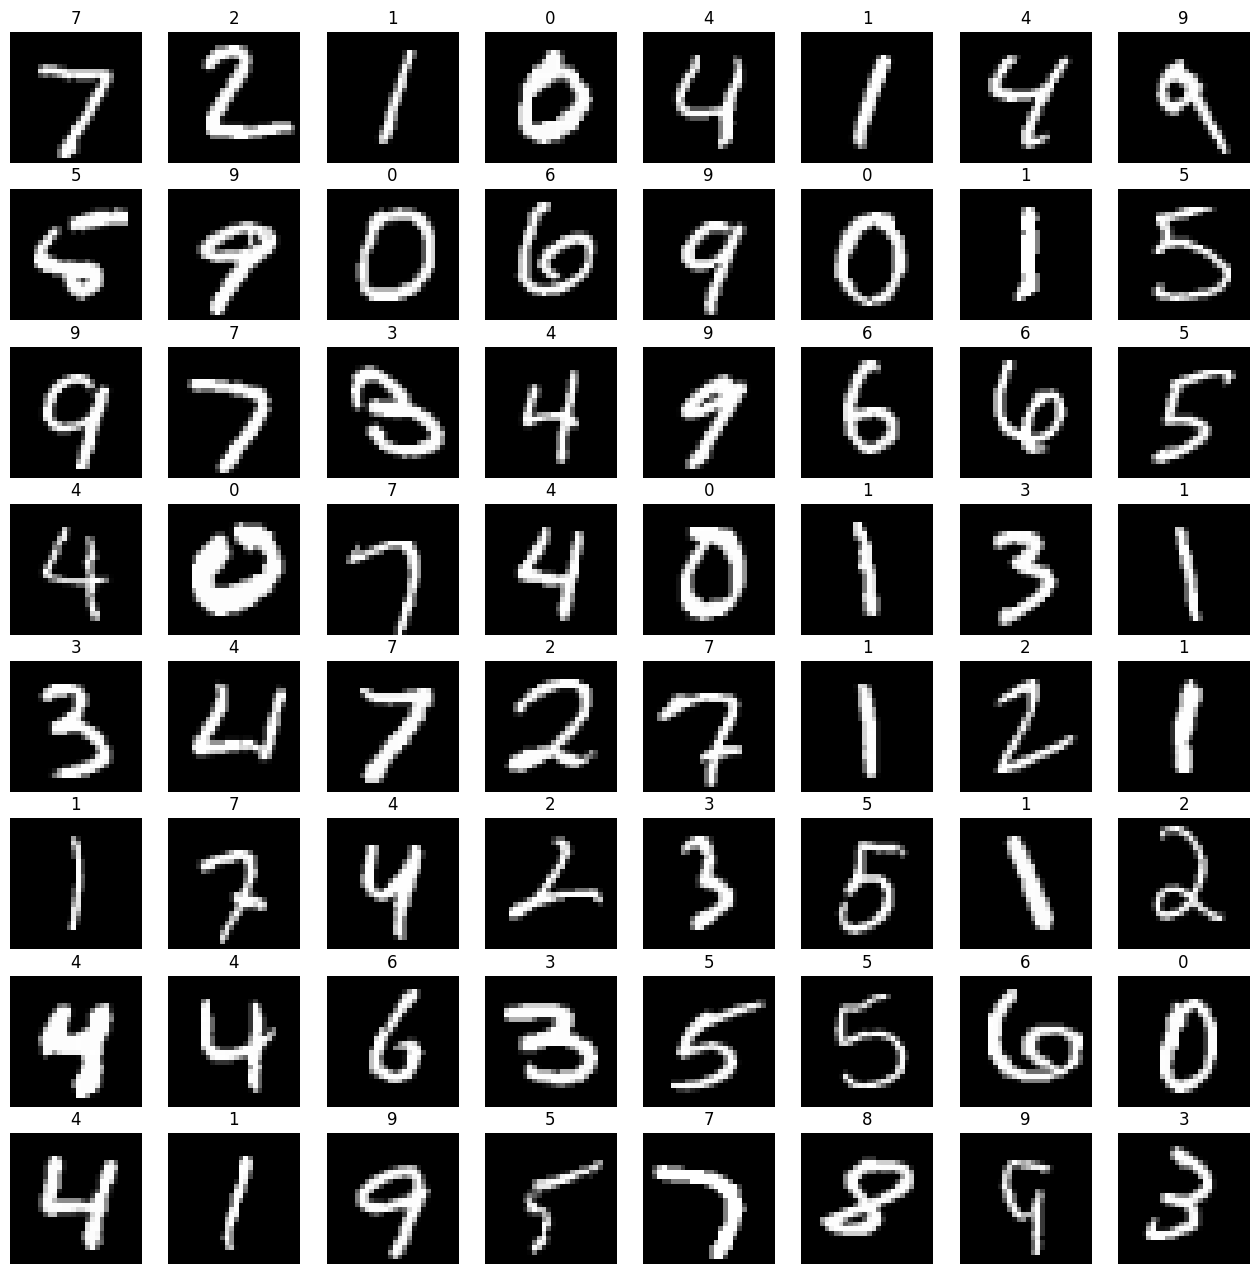

In [21]:
imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [22]:
model.eval() # 모델을 테스트 모드로 전환

sum_accuracy = 0

for x_batch, y_batch in test_loader :
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis = 1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accuracy = sum_accuracy + acc

    avg_acc = sum_accuracy / len(test_loader)
print(f'테스트 정확도는 {avg_acc : .2f}% 입니다.')


테스트 정확도는  98.84% 입니다.


# **3. 동그라미, 엑스, 세모 분류하기**

* 동그라미 엑스 세모를 그림판에 여러가지 이미지를 저장 후 cnn으로 학습을 시켜 해당 데이터를 분류하는 모델을 만들어 보자

In [23]:
import pandas as pd
import torchvision

In [24]:
%cd /content/drive/MyDrive/Korea it 아카데미/DeepLearning/data

/content/drive/MyDrive/Korea it 아카데미/DeepLearning/data


In [25]:
# !unzip -qq "/content/drive/MyDrive/Korea it 아카데미/DeepLearning/data/shape.zip"

In [26]:
# 데이터 경로

train_path = '/content/drive/MyDrive/Korea it 아카데미/DeepLearning/data/shape/train'
test_path = '/content/drive/MyDrive/Korea it 아카데미/DeepLearning/data/shape/test'

In [27]:
# 이미지를 28 * 28 로 변환
# 그레이스케일 적용
# 텐서 변환
# 정규화 적용
# 색 반전(배경 : 흰색 -> 검정색, 글, 그림 : 검정색 -> 흰색)

transformer = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.RandomInvert(1)
])

In [28]:
trainset = torchvision.datasets.ImageFolder(root = train_path, transform =transformer)
testset = torchvision.datasets.ImageFolder(root = test_path, transform =transformer)

In [29]:
len(trainset), len(testset)

(240, 60)

In [30]:
trainset.classes, testset.classes

(['cir', 'tri', 'x'], ['cir', 'tri', 'x'])

In [31]:
class_map = {
    0 : 'cir',
    1 : 'tri',
    2 : 'x'
}

In [32]:
loader = DataLoader(
    dataset = trainset,
    batch_size = 8,
    shuffle = True
)

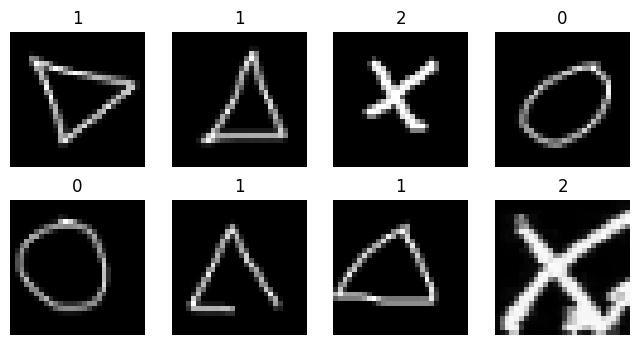

In [33]:
imgs, labels = next(iter(loader))
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [34]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size = 3, padding = 'same'),
    nn.ReLU(),

    nn.Conv2d(32, 32, kernel_size = 3, padding = 'same'),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size = 2),
    nn.Dropout(0.25),

    nn.Conv2d(32, 64, kernel_size = 3, padding = 'same'),
    nn.ReLU(),

    nn.Conv2d(64, 64, kernel_size = 3, padding = 'same'),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size = 2),
    nn.Dropout(0.25),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 3)

).to(device)

In [35]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25, inplace=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=3136, out_features=3, bias=True)
)

In [36]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 20

for epoch in range(epochs + 1) :
    sum_losses = 0
    sum_acc = 0

    for x_batch, y_batch in loader :
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis = 1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_acc = sum_acc + acc

    avg_losses = sum_losses / len(loader)
    avg_acc = sum_acc / len(loader)


    if epoch % 10 == 0 :
        print(f'Epoch : {epoch : 4d} / {epochs} Loss : {avg_loss : .6f} Accuracy : {avg_accuracy : .2f}%')

Epoch :    0 / 20 Loss :  0.007884 Accuracy :  99.72%
Epoch :   10 / 20 Loss :  0.007884 Accuracy :  99.72%
Epoch :   20 / 20 Loss :  0.007884 Accuracy :  99.72%


In [37]:
test_loader = DataLoader(
    dataset = testset,
    batch_size = 8,
    shuffle = True
)

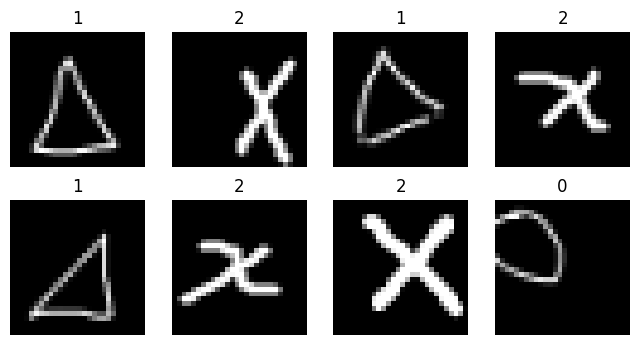

In [38]:
imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [39]:
model.eval()

sum_acc = 0

img_list = torch.Tensor().to(device)
y_pred_list = torch.Tensor().to(device)
y_true_list = torch.Tensor().to(device)

for x_batch, y_batch in test_loader :
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_pred, axis = 1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_acc = sum_acc + acc

    y_pred_list = torch.cat((y_pred_list, y_pred_index), dim = 0)
    y_true_list = torch.cat((y_true_list, y_batch), dim = 0)
    img_list = torch.cat((img_list, x_batch), dim = 0)

avg_acc = sum_acc / len(test_loader)

print(f'테스트 정확도는 {avg_acc : .2f}% 입니다.')

테스트 정확도는  92.19% 입니다.


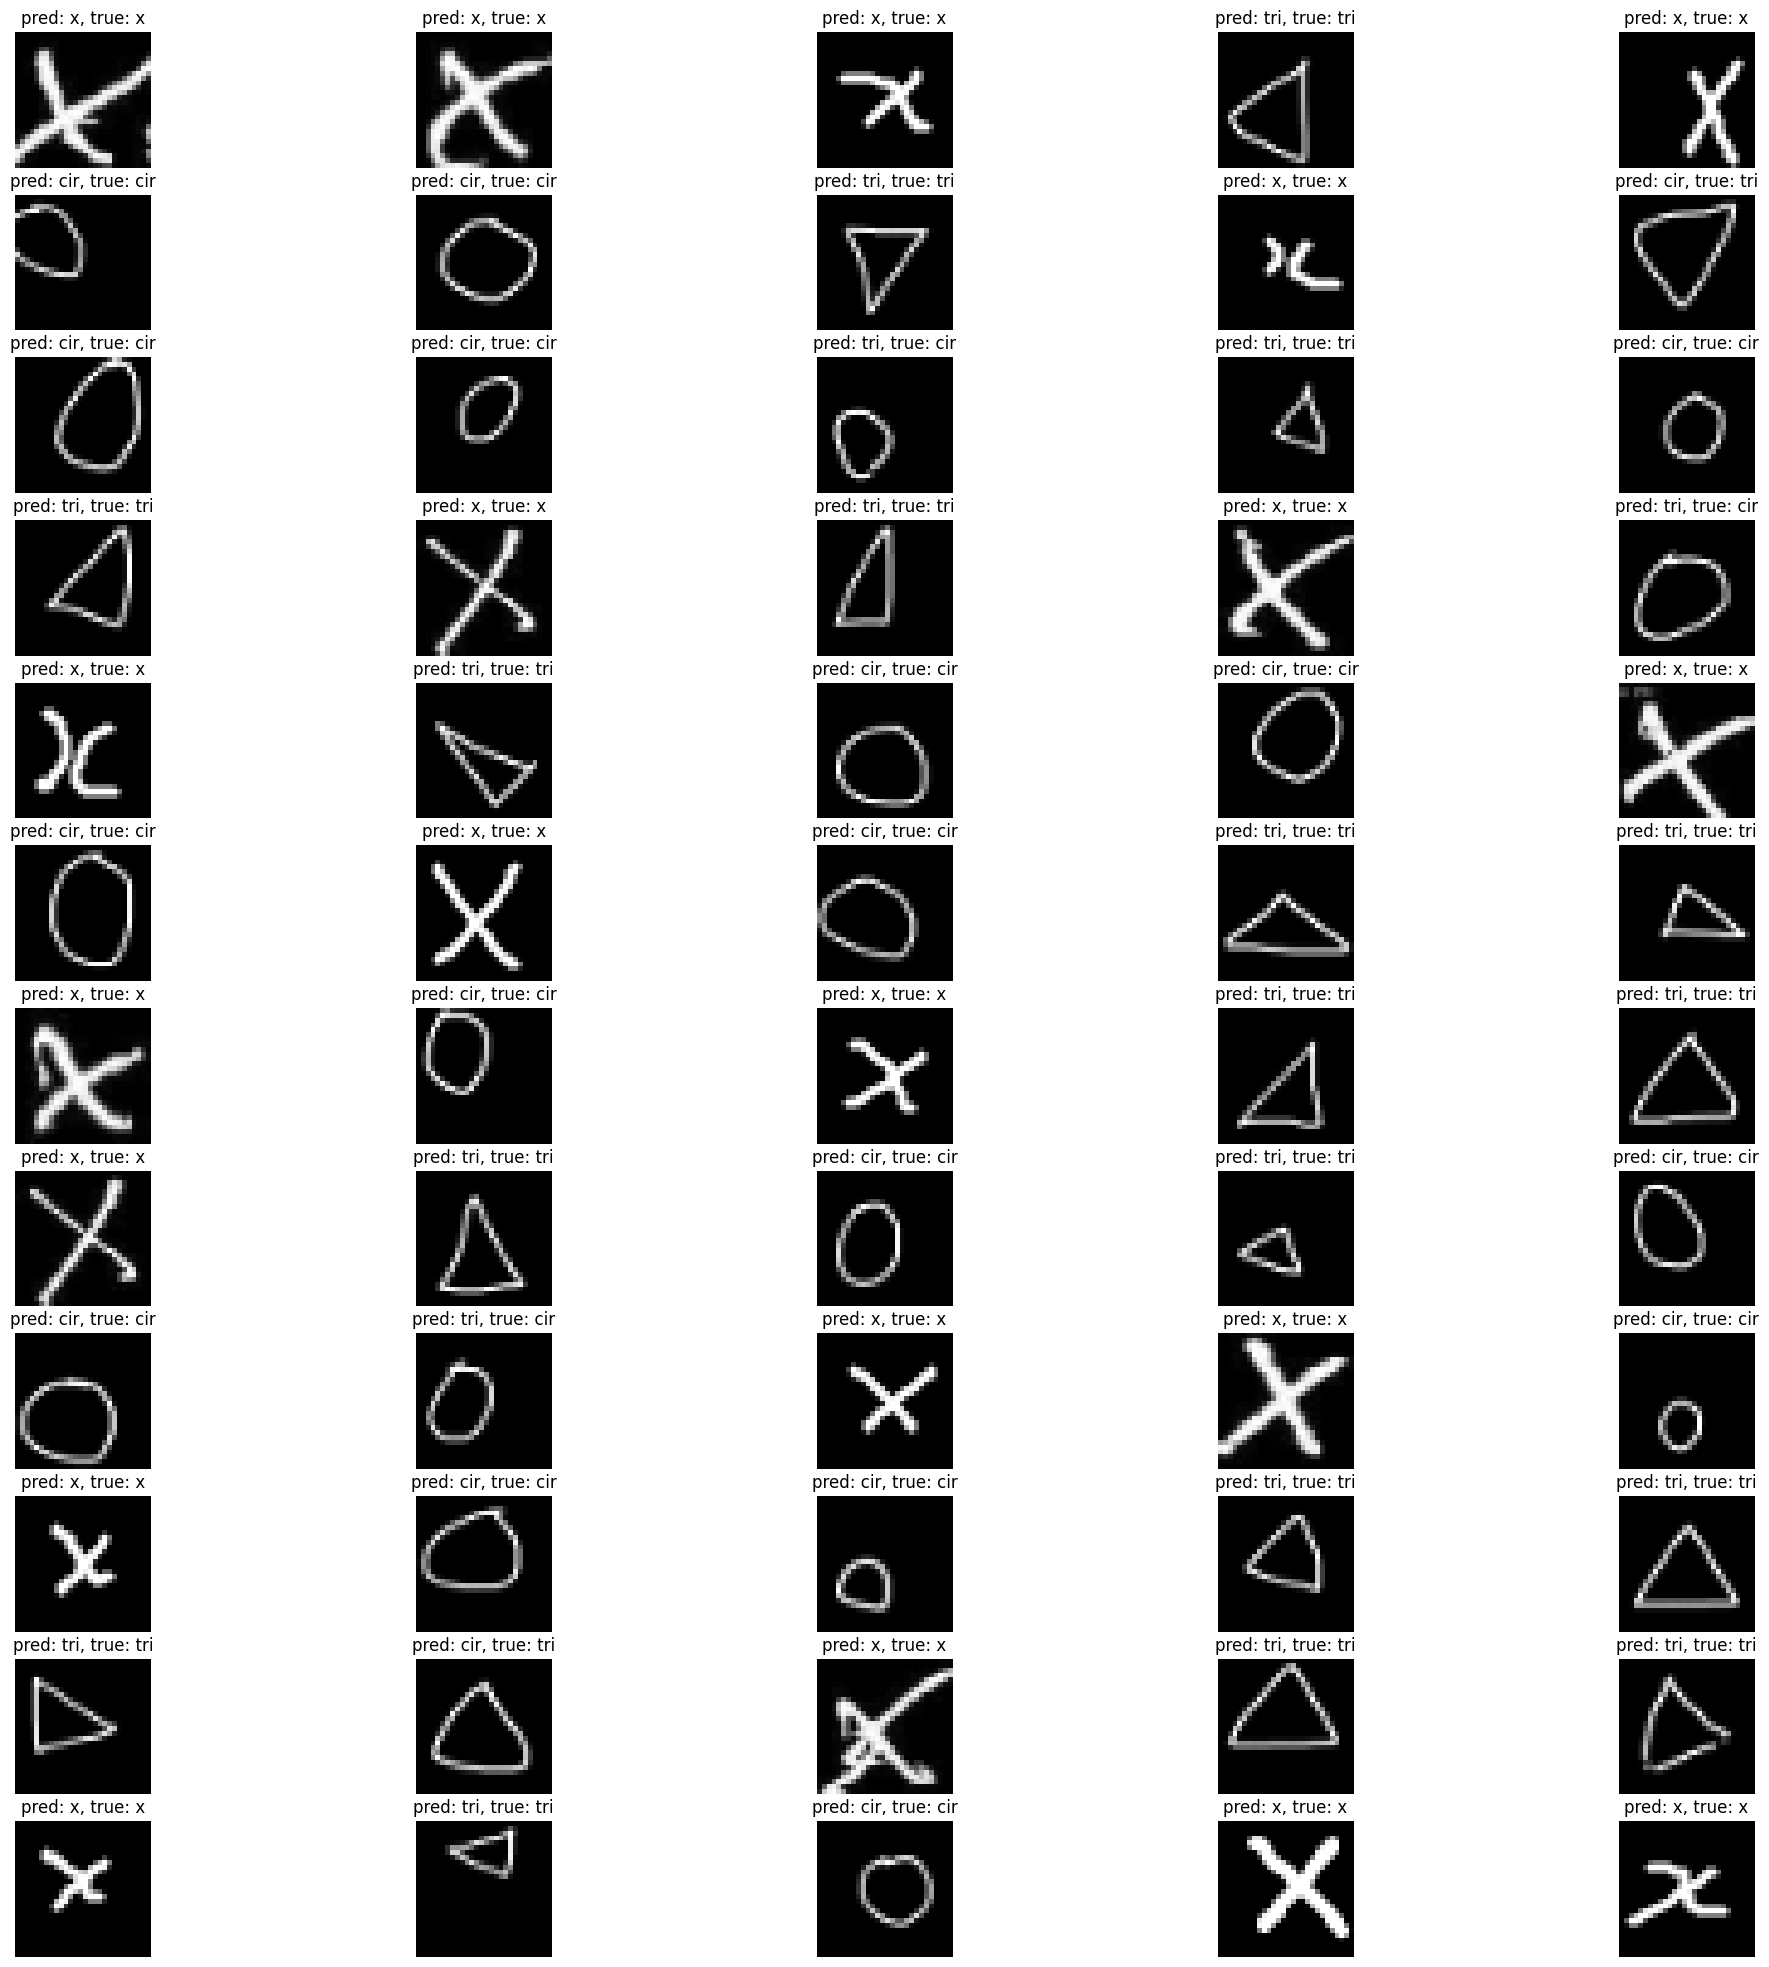

In [40]:
fig, axes = plt.subplots(12, 5, figsize=(25, 25))

img_list_cpu = img_list.cpu()
y_pred_list_cpu = y_pred_list.cpu()
y_true_list_cpu = y_true_list.cpu()

for ax, img, y_pred, y_true in zip(axes.flatten(), img_list_cpu, y_pred_list_cpu, y_true_list_cpu):
  ax.imshow(img.reshape(28, 28), cmap='gray')
  ax.set_title(f'pred: {class_map[y_pred.item()]}, true: {class_map[y_true.item()]}')
  ax.axis('off')

plt.show()
